# Deep Convolutional Generative Adversarial Network Example

Build a deep convolutional generative adversarial network (DCGAN) to generate digit images from a noise distribution with TensorFlow.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## DCGAN Overview

<img src="https://camo.githubusercontent.com/45e147fc9dfcf6a8e5df2c9b985078258b9974e3/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313030302f312a33394e6e6e695f6e685044614c7539416e544c6f57772e706e67" alt="dcgan" style="width: 1000px;"/>

References:
- [Unsupervised representation learning with deep convolutional generative adversarial networks](https://arxiv.org/pdf/1511.06434). A Radford, L Metz, S Chintala, 2016.
- [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html). X Glorot, Y Bengio. Aistats 9, 249-256
- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). Sergey Ioffe, Christian Szegedy. 2015.

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Training Params
num_steps = 10000
batch_size = 128
lr_generator = 0.002
lr_discriminator = 0.002

# Network Params
image_dim = 784 # 28*28 pixels * 1 channel
noise_dim = 100 # Noise data points

In [4]:
# Build Networks
# Network Inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
# A boolean to indicate batch normalization if it is training or inference time
is_training = tf.placeholder(tf.bool)

#LeakyReLU activation
def leakyrelu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)

def residual_block(x, filters, strides, projection_shortcut=None):
    shortcut = x
    ## A residual unit
    if projection_shortcut is not None:
        shortcut = projection_shortcut(x, filters, strides)
        shortcut = tf.layers.batch_normalization(inputs=shortcut, training=is_training)

    # We halve the input at the first convolution layer
    conv1 = tf.layers.conv2d(x, filters=filters, kernel_size=(3, 3), strides=strides, padding='same')
    conv1_batch_norm = tf.layers.batch_normalization(conv1, training=is_training)
    conv1_batch_norm_relu = leakyrelu(conv1_batch_norm)

    conv2 = tf.layers.conv2d(conv1_batch_norm_relu, filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv2_batch_norm = tf.layers.batch_normalization(conv2, training=is_training)
    conv2_batch_norm_relu = leakyrelu(conv2_batch_norm)

    return conv2_batch_norm_relu + shortcut
    ## End of the residual unit

def residual_block_transpose(x, filters, strides, projection_shortcut_residual=None):
    shortcut = x
    ## A residual unit
    if projection_shortcut_residual is not None:
        shortcut = projection_shortcut_residual(x, filters, strides)
        shortcut = tf.layers.batch_normalization(inputs=shortcut, training=is_training)

    # We halve the input at the first convolution layer
    conv1 = tf.layers.conv2d_transpose(x, filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv1_batch_norm = tf.layers.batch_normalization(conv1, training=is_training)
    conv1_batch_norm_relu = tf.nn.relu(conv1_batch_norm)

    conv2 = tf.layers.conv2d_transpose(conv1_batch_norm_relu, filters=filters, kernel_size=(3, 3), strides=strides, padding='same')
    conv2_batch_norm = tf.layers.batch_normalization(conv2, training=is_training)
    conv2_batch_norm_relu = tf.nn.relu(conv2_batch_norm)

    return conv2_batch_norm_relu - shortcut
    ## End of the residual unit

def projection_shortcut(x, filters, strides):
    return tf.layers.conv2d(inputs=x, filters=filters, kernel_size=(1, 1), strides=strides, padding='same')

def projection_shortcut_residual(x, filters, strides):
    return tf.layers.conv2d_transpose(inputs=x, filters=filters, kernel_size=(1, 1), strides=strides, padding='same')

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
def generator(x, reuse=False):
    print("generator")
    with tf.variable_scope('Generator', reuse=reuse):
        # TensorFlow Layers automatically create variables and calculate their
        # shape, based on the input.
        x = tf.layers.dense(x, units=7 * 7 * 128)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        print(x)
        # Deconvolution, image shape: [?x7x7x128]
        x = residual_block_transpose(x, filters=128, strides=(1, 1))
        print(x)
        ## double the image size and halve the depths
        # image shape: [?x14x14x64]
        x = residual_block_transpose(x, filters=64, strides=(2, 2), projection_shortcut_residual = projection_shortcut_residual)
        print(x)
        #x = residual_block_transpose(x, filters=64)
        ## double the image size and halve the depths
        # image shape: [?x28x28x32]
        x = residual_block_transpose(x, filters=32, strides=(2, 2), projection_shortcut_residual = projection_shortcut_residual)
        print(x)
        #x = residual_block_transpose(x, filters=32)
        ## Make the depth back to 1
        x = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        print(x)
        # Apply tanh for better stability - clip values to [-1, 1].
        x = tf.nn.tanh(x)
        return x


# Discriminator Network
# Input: Image, Output: Prediction Real/Fake Image
def discriminator(x, reuse=False):
    print("discriminator")
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Typical convolutional neural network to classify images.
        # INPUT: [?x28x28x1]
        print(x)
        x = tf.layers.conv2d(x, filters=32, kernel_size=(1, 1), strides=(1, 1), padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        print(x)
        # [?x28x28x32]
        ## Start of the res-net structure
        x = residual_block(x, filters=32, strides=(1, 1))
        print(x)
        ### halve the size
        # [?x14x14x64]
        x = residual_block(x, filters=64, strides=(2, 2), projection_shortcut = projection_shortcut)
        print(x)
        #x = residual_block(x, filters=64)
        ## halve the size
        # [?x7x7x128]
        x = residual_block(x, filters=128, strides=(2, 2), projection_shortcut = projection_shortcut)
        print(x)
        #x = residual_block(x, filters=128)
        # Flatten
        x = tf.reshape(x, shape=[-1, 7 * 7 * 128])
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Output 2 classes: Real and Fake images
        x = tf.layers.dense(x, 2)
        return x

# Build Generator Network
gen_sample = generator(noise_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample, reuse=True)

# Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

# Build Loss (Labels for real images: 1, for fake images: 0)
# Discriminator Loss for real and fake samples
disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
# Sum both loss
disc_loss = disc_loss_real + disc_loss_fake
# Generator Loss (The generator tries to fool the discriminator, thus labels are 1)
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=tf.ones([batch_size], dtype=tf.int32)))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# Discriminator Network Variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
# TensorFlow UPDATE_OPS collection holds all batch norm operation to update the moving mean/stddev
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
# `control_dependencies` ensure that the `gen_update_ops` will be run before the `minimize` op (backprop)
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
    
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

generator
Tensor("Generator/Reshape:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Generator/sub:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Generator/sub_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Generator/sub_2:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Generator/Relu_7:0", shape=(?, 28, 28, 1), dtype=float32)
discriminator
Tensor("Placeholder_1:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("Discriminator/add:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Discriminator/add_3:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Discriminator/add_6:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Discriminator/add_9:0", shape=(?, 7, 7, 128), dtype=float32)
discriminator
Tensor("Generator/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("Discriminator_1/add:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Discriminator_1/add_3:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Discriminator_1/add_6:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Discrimi

In [5]:
# Testing
# Generate images from noise, using the generator network.
def test_display():
    n = 6
    canvas = np.empty((28 * n, 28 * n))
    for i in range(n):
        # Noise input.
        z = np.random.uniform(-1., 1., size=[n, noise_dim])
        # Generate image from noise.
        g = sess.run(gen_sample, feed_dict={noise_input: z, is_training:False})
        # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
        g = (g + 1.) / 2.
        # Reverse colours for better display
        g = -1 * (g - 1)
        for j in range(n):
            # Draw the generated digits
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

    plt.figure(figsize=(n, n))
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()

Step 1: Generator Loss: 2.385346, Discriminator Loss: 1.828290


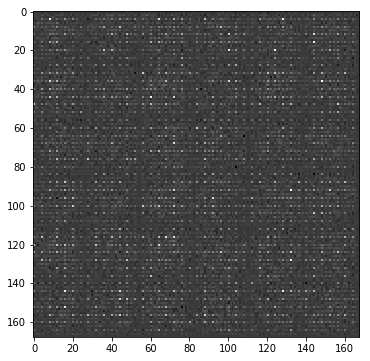

Step 100: Generator Loss: 0.807208, Discriminator Loss: 1.270706


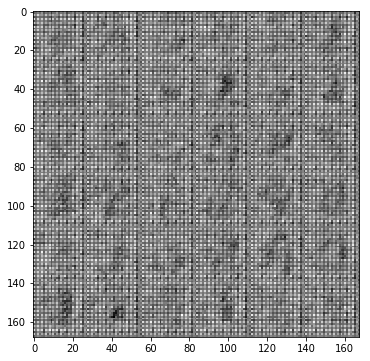

Step 200: Generator Loss: 0.989548, Discriminator Loss: 1.092592


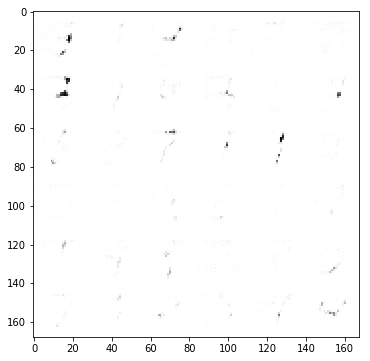

Step 300: Generator Loss: 1.633120, Discriminator Loss: 0.784868


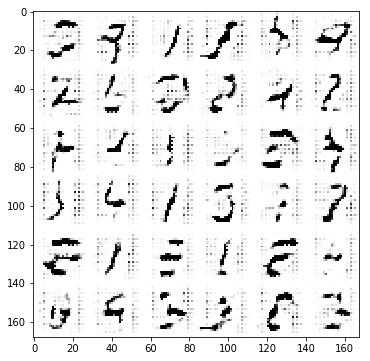

Step 400: Generator Loss: 1.527301, Discriminator Loss: 1.055044


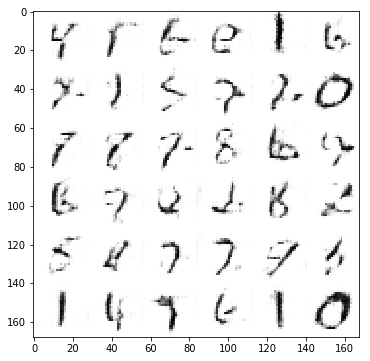

Step 500: Generator Loss: 1.448680, Discriminator Loss: 1.058189


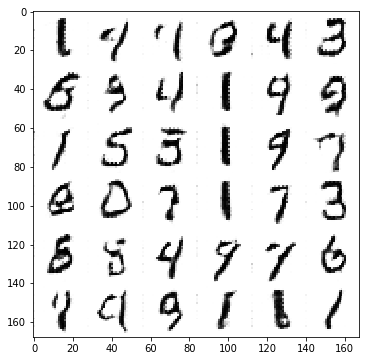

Step 600: Generator Loss: 1.059394, Discriminator Loss: 1.268965


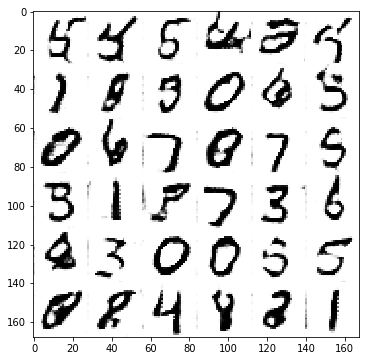

Step 700: Generator Loss: 1.530045, Discriminator Loss: 0.890768


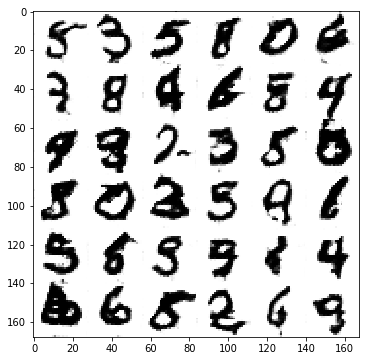

Step 800: Generator Loss: 2.016584, Discriminator Loss: 1.222312


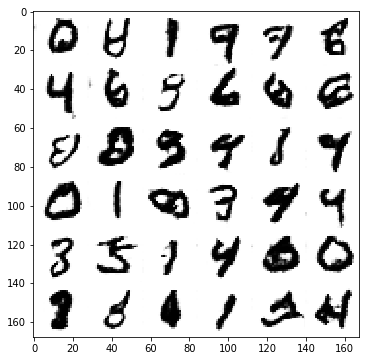

Step 900: Generator Loss: 1.602496, Discriminator Loss: 1.127110


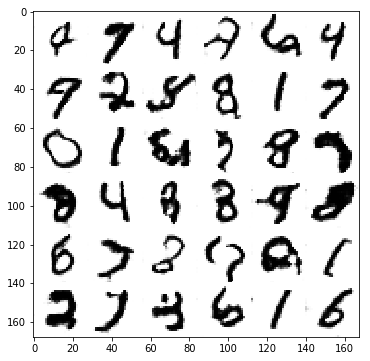

Step 1000: Generator Loss: 1.245323, Discriminator Loss: 0.968361


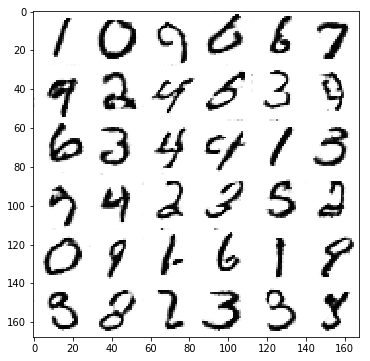

Step 1100: Generator Loss: 1.269391, Discriminator Loss: 1.176620


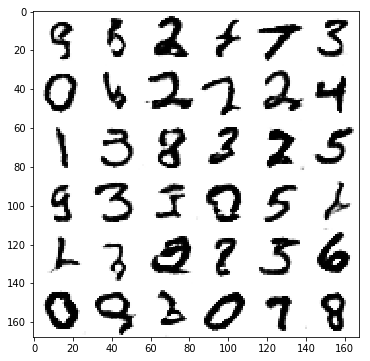

Step 1200: Generator Loss: 1.083373, Discriminator Loss: 1.032152


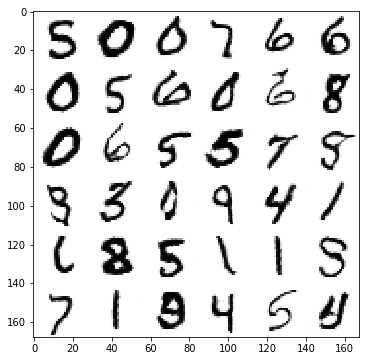

Step 1300: Generator Loss: 3.744603, Discriminator Loss: 0.978494


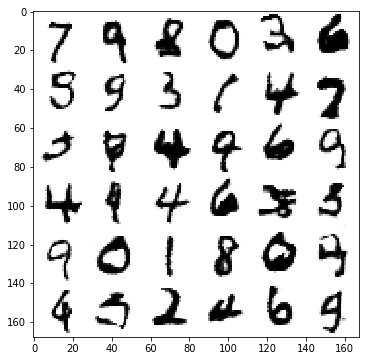

Step 1400: Generator Loss: 2.170672, Discriminator Loss: 0.944499


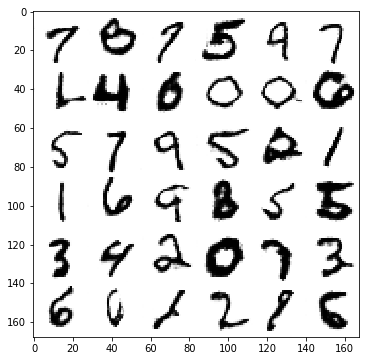

Step 1500: Generator Loss: 1.400233, Discriminator Loss: 0.753229


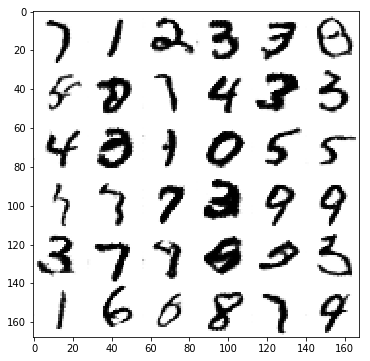

Step 1600: Generator Loss: 1.846225, Discriminator Loss: 0.729033


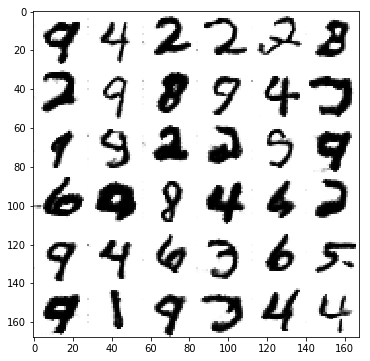

Step 1700: Generator Loss: 1.068930, Discriminator Loss: 0.691036


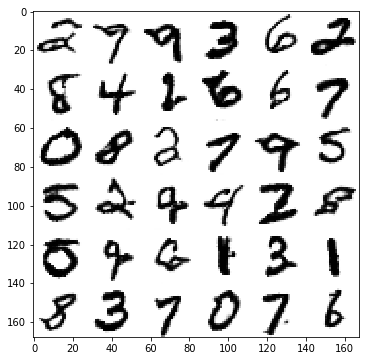

Step 1800: Generator Loss: 2.236115, Discriminator Loss: 0.767472


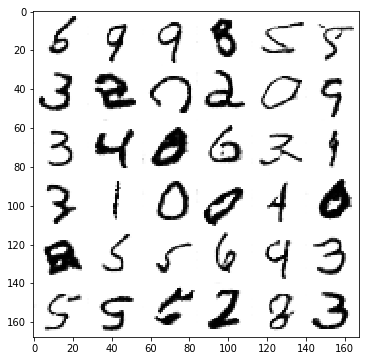

Step 1900: Generator Loss: 2.336133, Discriminator Loss: 0.889334


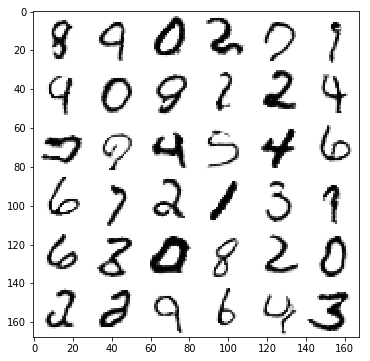

Step 2000: Generator Loss: 2.373430, Discriminator Loss: 0.902469


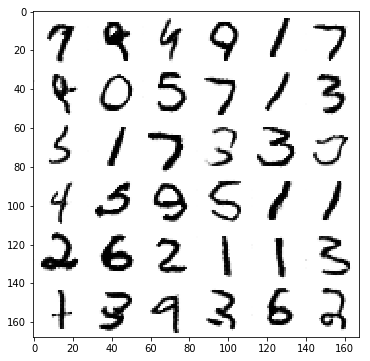

Step 2100: Generator Loss: 4.029549, Discriminator Loss: 1.155901


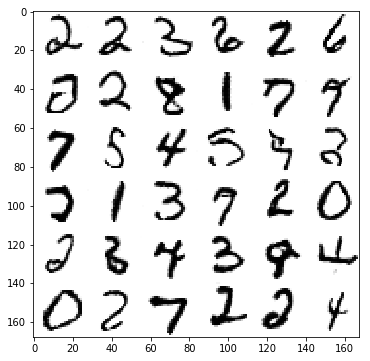

Step 2200: Generator Loss: 4.231393, Discriminator Loss: 1.019071


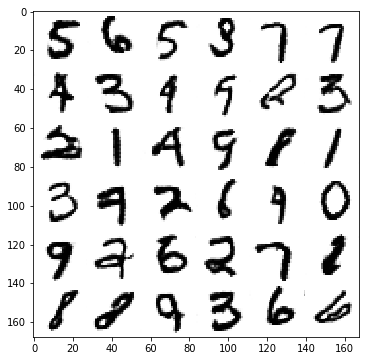

Step 2300: Generator Loss: 1.751229, Discriminator Loss: 1.284472


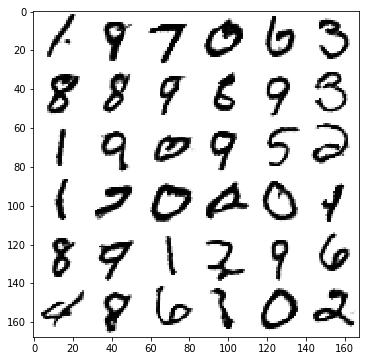

Step 2400: Generator Loss: 2.273842, Discriminator Loss: 0.853913


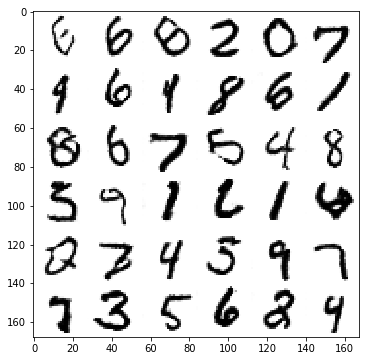

Step 2500: Generator Loss: 2.532374, Discriminator Loss: 0.647721


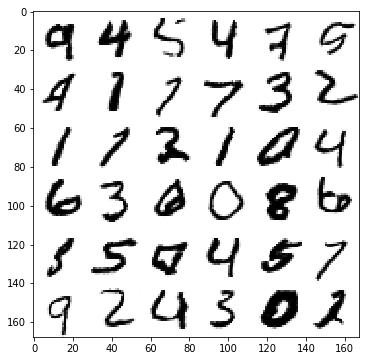

Step 2600: Generator Loss: 3.327404, Discriminator Loss: 0.485349


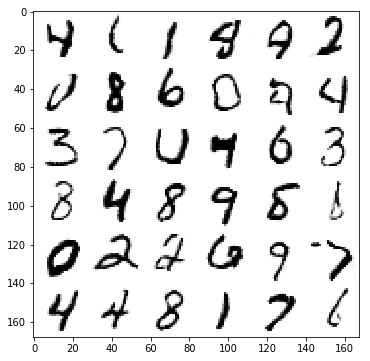

Step 2700: Generator Loss: 2.260203, Discriminator Loss: 0.713989


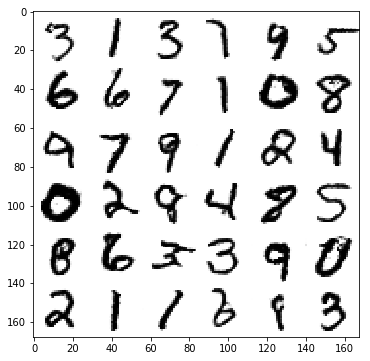

Step 2800: Generator Loss: 2.295526, Discriminator Loss: 0.478935


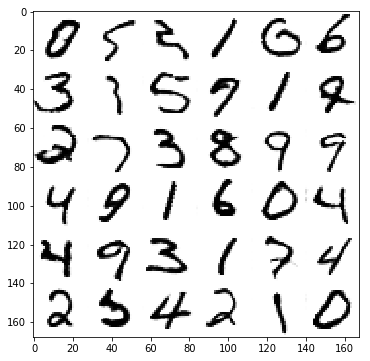

Step 2900: Generator Loss: 2.151946, Discriminator Loss: 0.614161


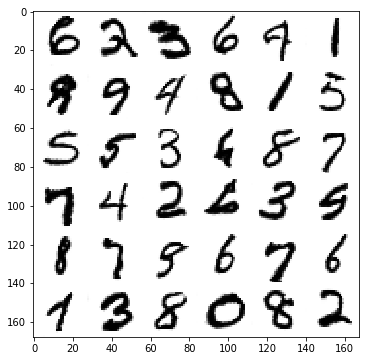

Step 3000: Generator Loss: 1.257183, Discriminator Loss: 1.067556


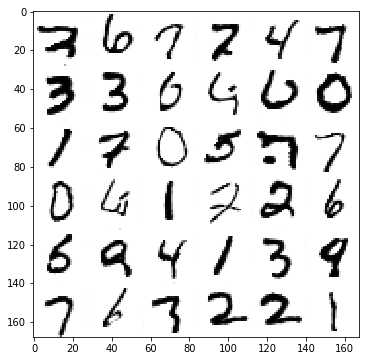

Step 3100: Generator Loss: 1.775180, Discriminator Loss: 0.687657


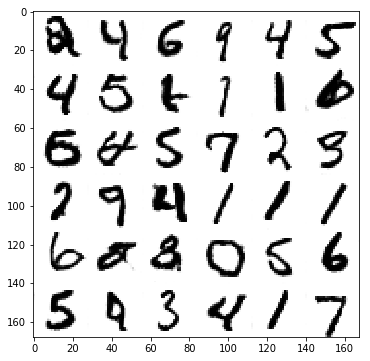

Step 3200: Generator Loss: 4.172910, Discriminator Loss: 0.455490


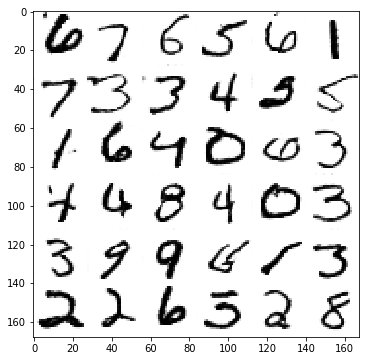

Step 3300: Generator Loss: 2.994841, Discriminator Loss: 0.418038


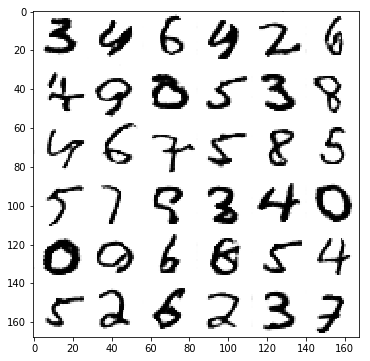

Step 3400: Generator Loss: 5.191589, Discriminator Loss: 0.303854


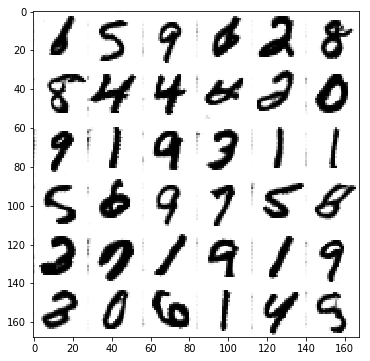

Step 3500: Generator Loss: 2.771156, Discriminator Loss: 0.557479


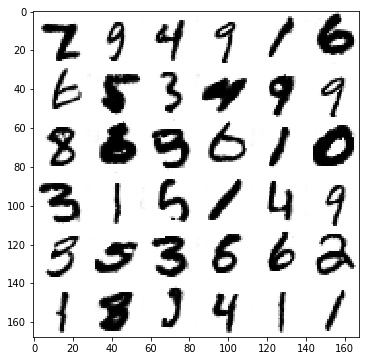

Step 3600: Generator Loss: 1.006743, Discriminator Loss: 0.465481


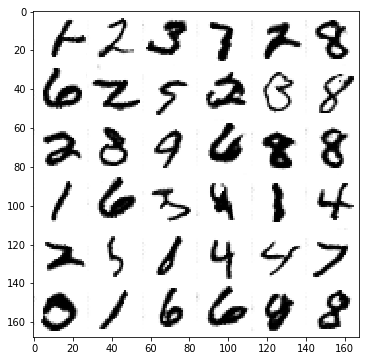

Step 3700: Generator Loss: 2.050396, Discriminator Loss: 0.196606


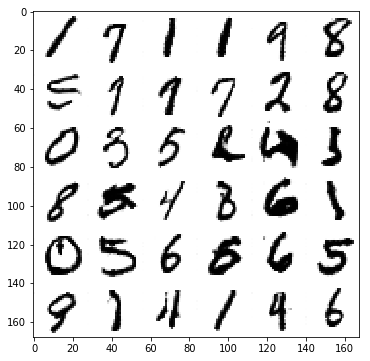

Step 3800: Generator Loss: 3.092535, Discriminator Loss: 0.273937


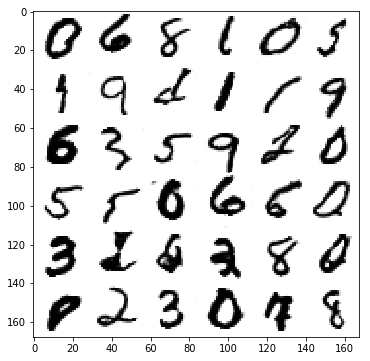

Step 3900: Generator Loss: 4.235382, Discriminator Loss: 0.531333


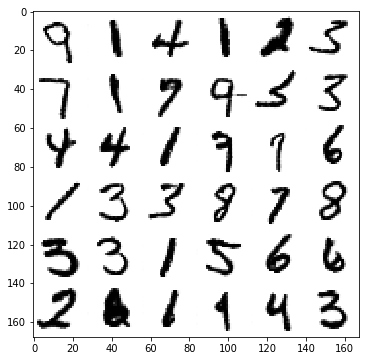

Step 4000: Generator Loss: 1.458684, Discriminator Loss: 0.363313


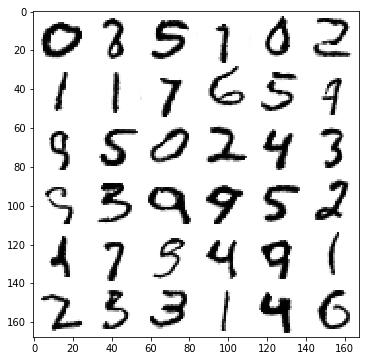

Step 4100: Generator Loss: 3.255938, Discriminator Loss: 0.943975


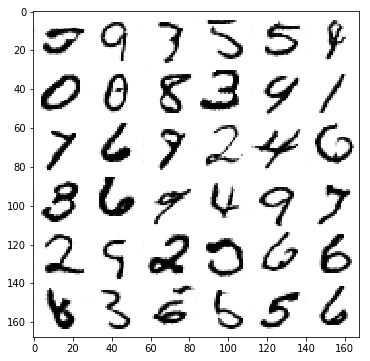

Step 4200: Generator Loss: 2.916227, Discriminator Loss: 0.801779


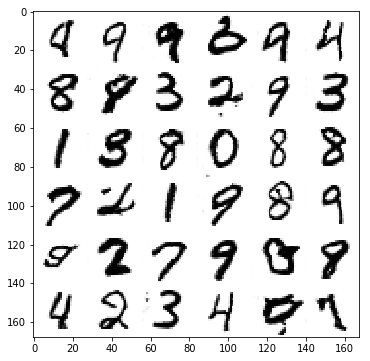

Step 4300: Generator Loss: 3.928184, Discriminator Loss: 0.294212


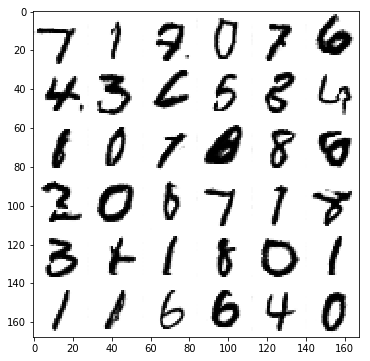

Step 4400: Generator Loss: 2.775167, Discriminator Loss: 0.261801


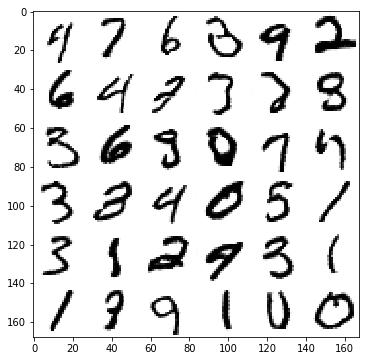

Step 4500: Generator Loss: 2.327856, Discriminator Loss: 0.562576


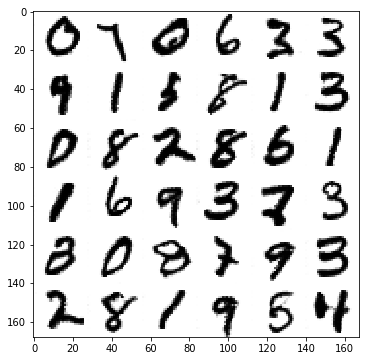

Step 4600: Generator Loss: 3.182456, Discriminator Loss: 0.181253


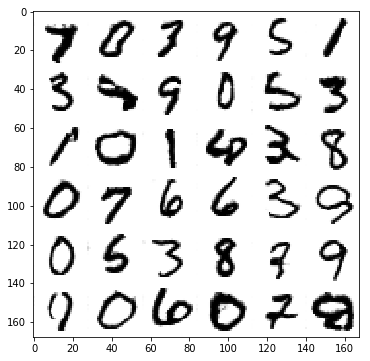

Step 4700: Generator Loss: 2.679244, Discriminator Loss: 0.525982


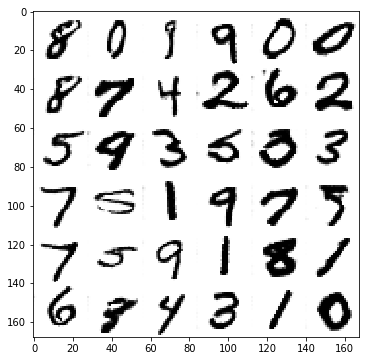

Step 4800: Generator Loss: 3.651108, Discriminator Loss: 0.311263


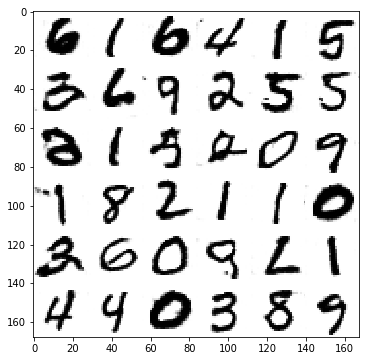

Step 4900: Generator Loss: 3.425695, Discriminator Loss: 0.305140


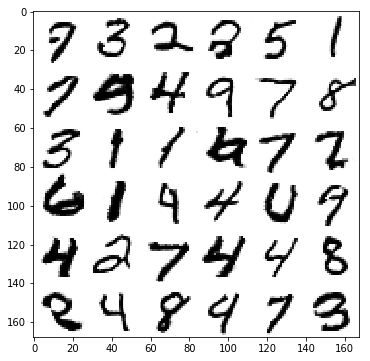

Step 5000: Generator Loss: 3.669912, Discriminator Loss: 0.460159


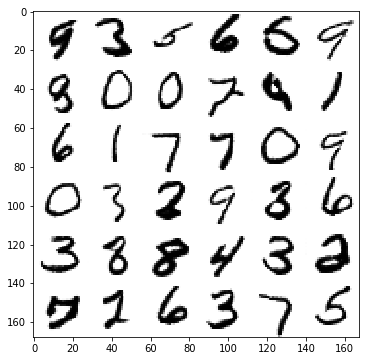

Step 5100: Generator Loss: 2.865378, Discriminator Loss: 0.428105


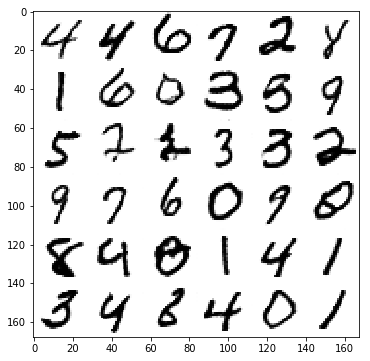

Step 5200: Generator Loss: 2.810680, Discriminator Loss: 0.376532


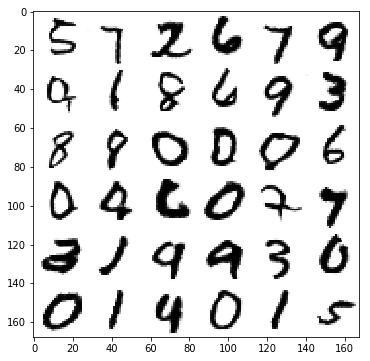

Step 5300: Generator Loss: 3.950941, Discriminator Loss: 0.265633


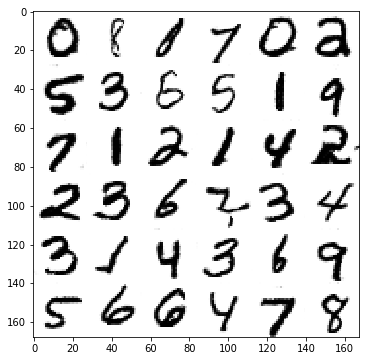

Step 5400: Generator Loss: 3.228891, Discriminator Loss: 0.566224


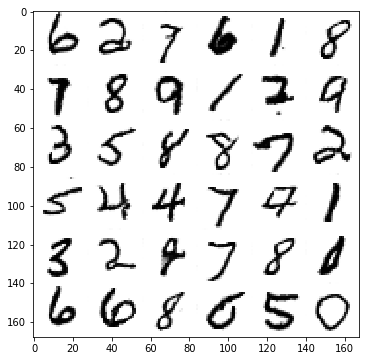

Step 5500: Generator Loss: 4.139342, Discriminator Loss: 0.156796


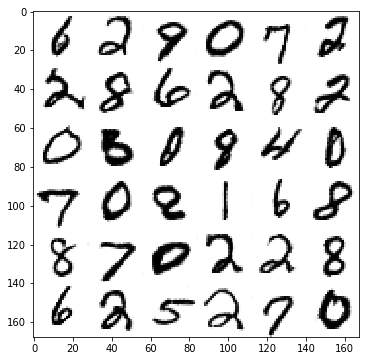

Step 5600: Generator Loss: 3.562716, Discriminator Loss: 0.221727


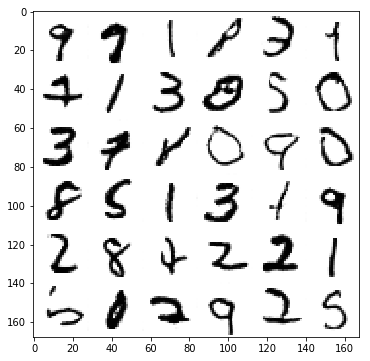

Step 5700: Generator Loss: 4.744300, Discriminator Loss: 0.278008


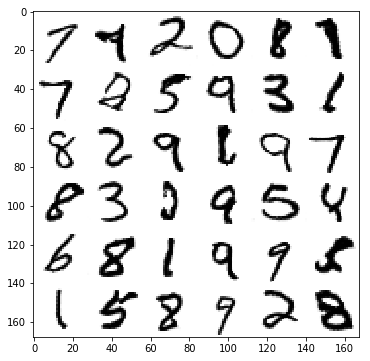

Step 5800: Generator Loss: 5.806473, Discriminator Loss: 0.377034


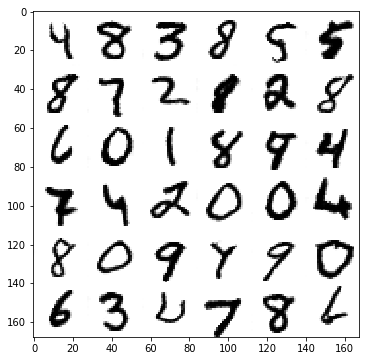

Step 5900: Generator Loss: 6.787782, Discriminator Loss: 0.491117


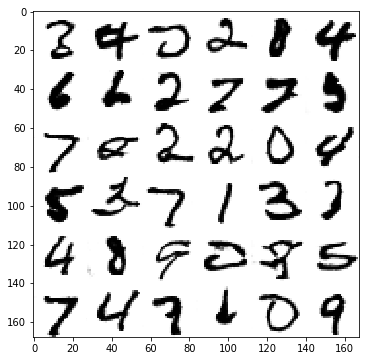

Step 6000: Generator Loss: 4.618875, Discriminator Loss: 0.542340


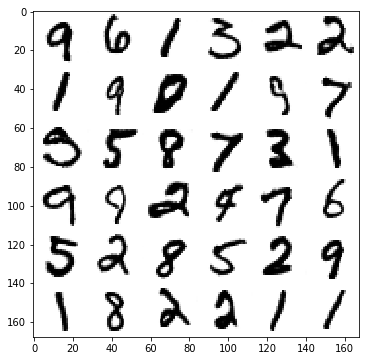

Step 6100: Generator Loss: 5.269632, Discriminator Loss: 0.173212


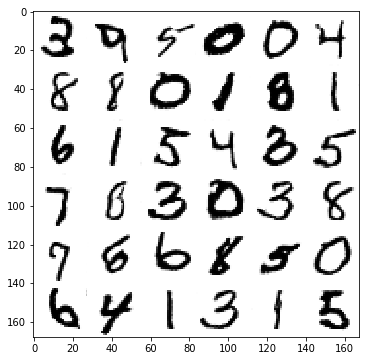

Step 6200: Generator Loss: 6.257211, Discriminator Loss: 0.119885


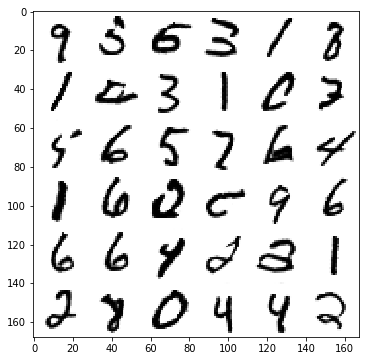

Step 6300: Generator Loss: 2.115737, Discriminator Loss: 0.429685


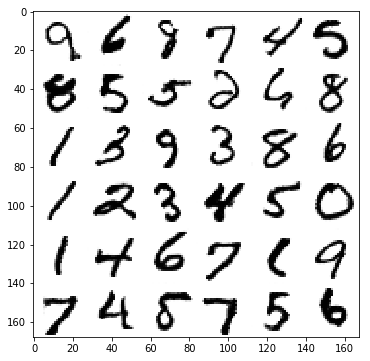

Step 6400: Generator Loss: 3.907905, Discriminator Loss: 0.118370


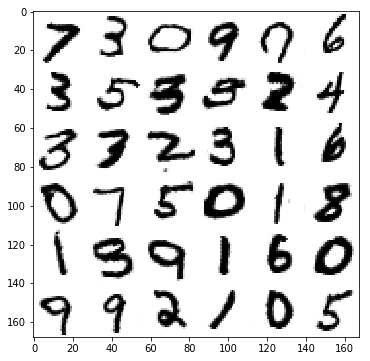

Step 6500: Generator Loss: 4.760163, Discriminator Loss: 0.140069


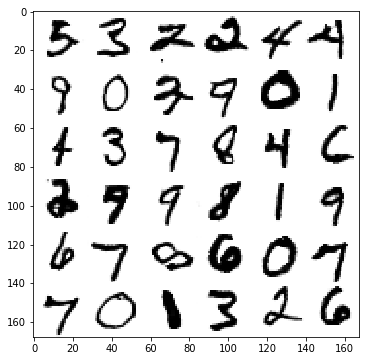

Step 6600: Generator Loss: 5.908166, Discriminator Loss: 0.091889


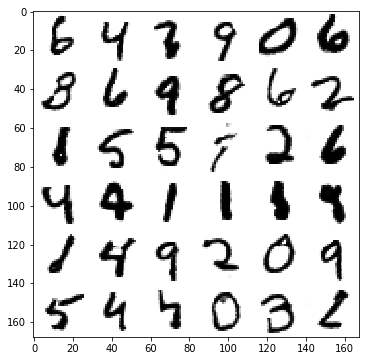

Step 6700: Generator Loss: 4.719291, Discriminator Loss: 0.102004


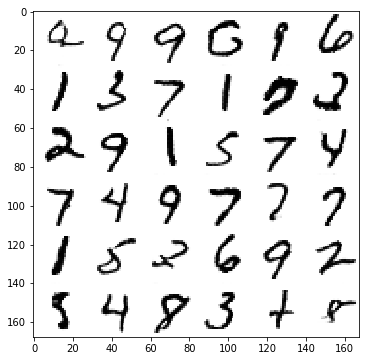

Step 6800: Generator Loss: 2.260623, Discriminator Loss: 0.519253


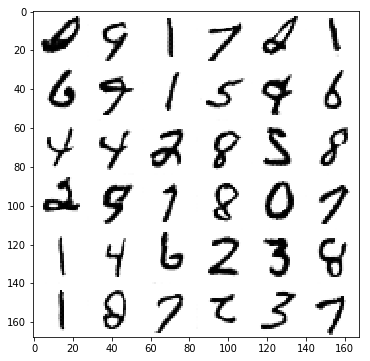

Step 6900: Generator Loss: 4.724440, Discriminator Loss: 0.143706


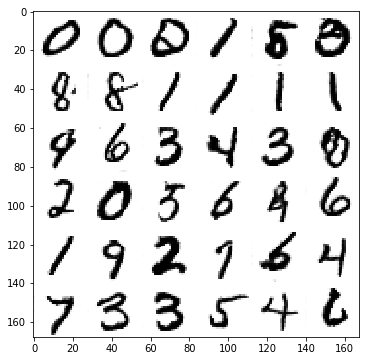

Step 7000: Generator Loss: 5.460778, Discriminator Loss: 0.180487


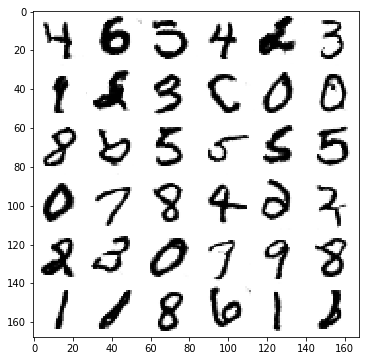

Step 7100: Generator Loss: 4.163877, Discriminator Loss: 0.039279


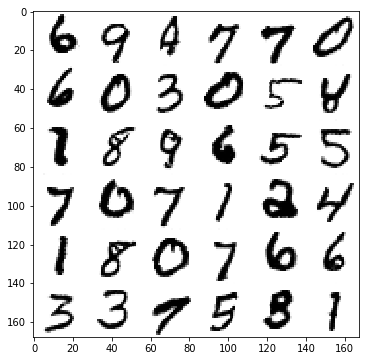

Step 7200: Generator Loss: 5.038428, Discriminator Loss: 0.202783


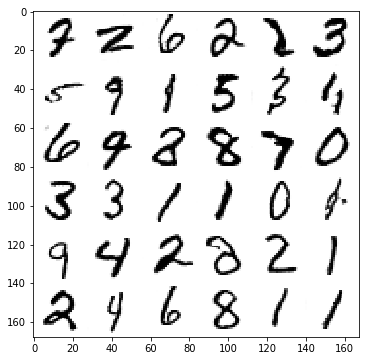

Step 7300: Generator Loss: 6.787924, Discriminator Loss: 0.124184


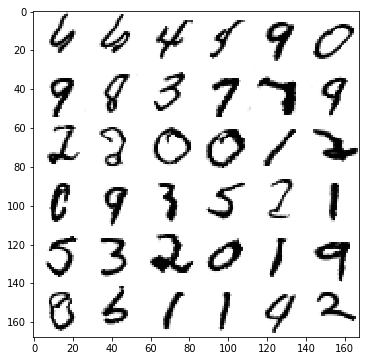

Step 7400: Generator Loss: 4.712270, Discriminator Loss: 0.112996


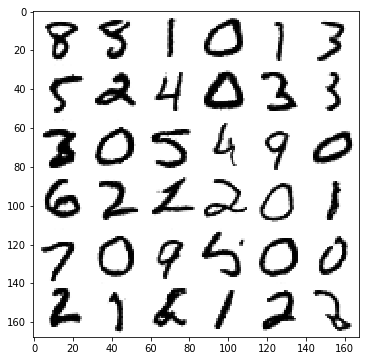

Step 7500: Generator Loss: 7.421475, Discriminator Loss: 0.129845


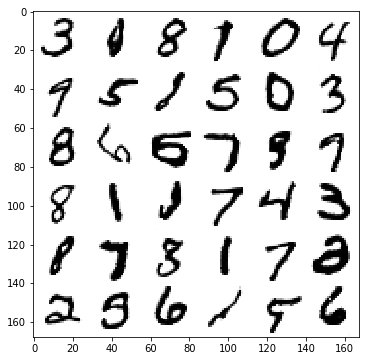

Step 7600: Generator Loss: 5.701819, Discriminator Loss: 0.052387


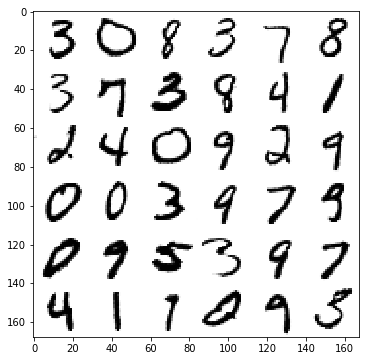

Step 7700: Generator Loss: 6.326636, Discriminator Loss: 0.509634


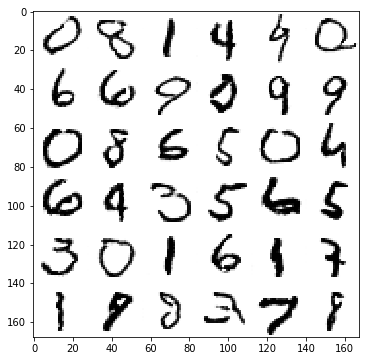

Step 7800: Generator Loss: 2.477471, Discriminator Loss: 0.757924


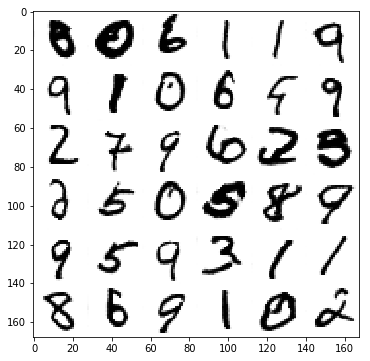

Step 7900: Generator Loss: 3.707620, Discriminator Loss: 2.328679


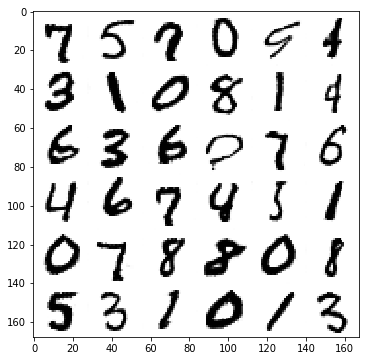

Step 8000: Generator Loss: 6.525204, Discriminator Loss: 0.310198


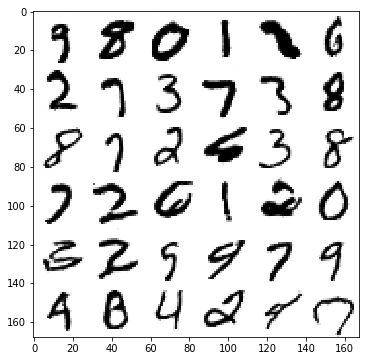

Step 8100: Generator Loss: 2.917215, Discriminator Loss: 0.241263


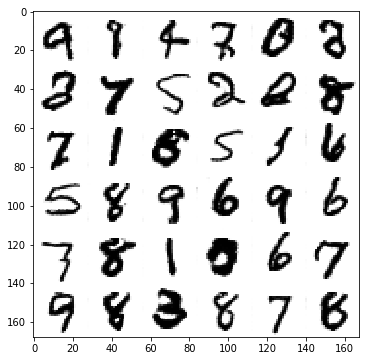

Step 8200: Generator Loss: 7.118404, Discriminator Loss: 0.045777


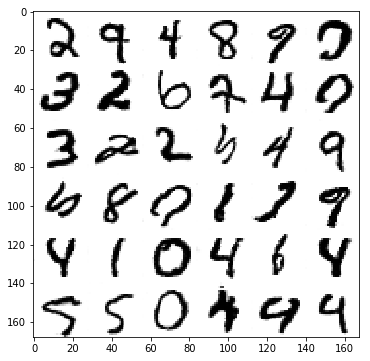

Step 8300: Generator Loss: 7.698193, Discriminator Loss: 1.693799


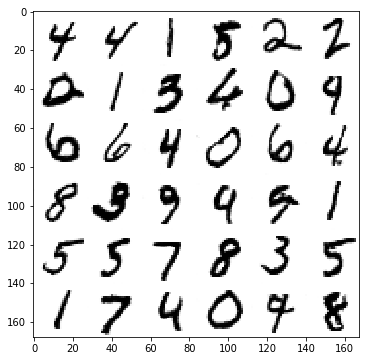

Step 8400: Generator Loss: 2.530409, Discriminator Loss: 0.226431


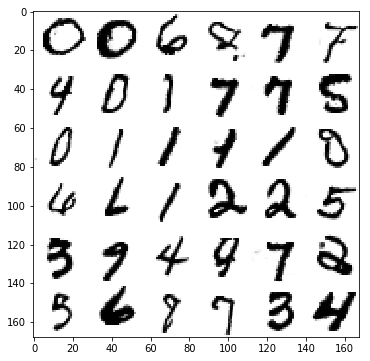

Step 8500: Generator Loss: 5.214252, Discriminator Loss: 0.034262


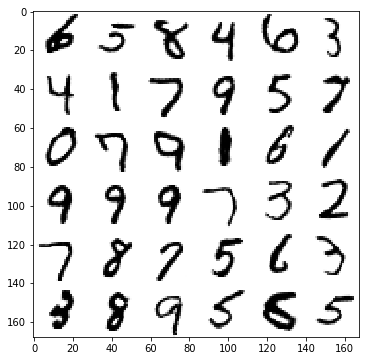

Step 8600: Generator Loss: 7.427880, Discriminator Loss: 0.099629


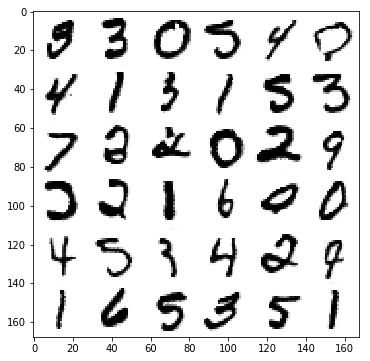

Step 8700: Generator Loss: 6.582786, Discriminator Loss: 0.049568


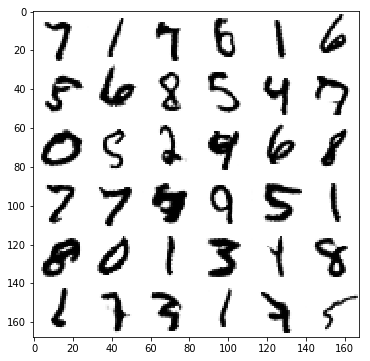

Step 8800: Generator Loss: 4.111775, Discriminator Loss: 0.103873


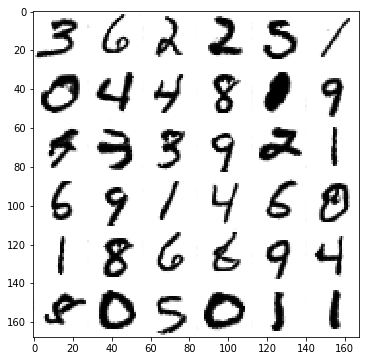

Step 8900: Generator Loss: 8.111268, Discriminator Loss: 0.550427


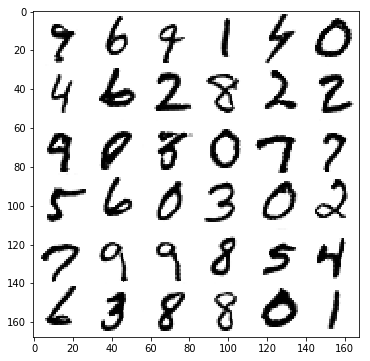

Step 9000: Generator Loss: 5.342860, Discriminator Loss: 0.263852


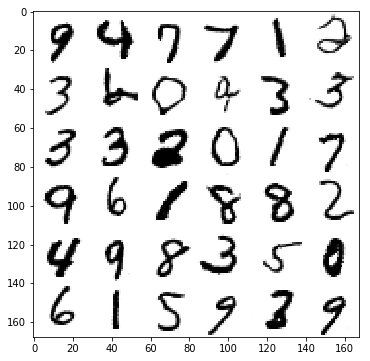

Step 9100: Generator Loss: 5.591976, Discriminator Loss: 0.156048


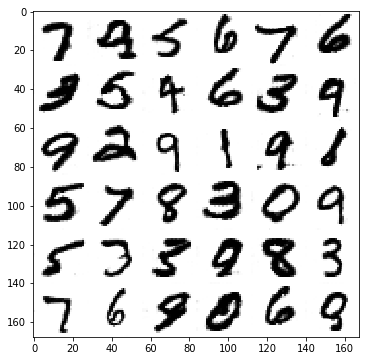

Step 9200: Generator Loss: 7.489110, Discriminator Loss: 0.200026


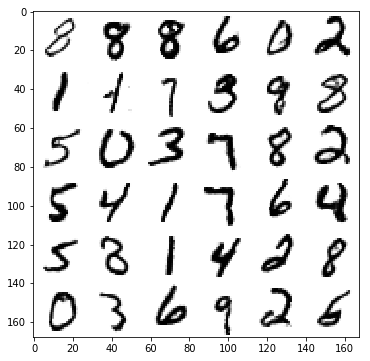

Step 9300: Generator Loss: 4.298918, Discriminator Loss: 1.388301


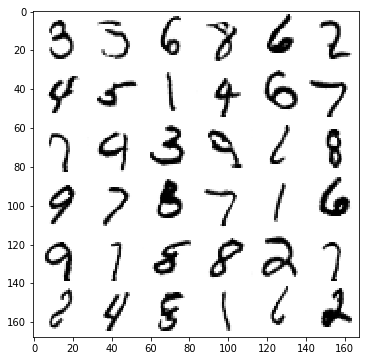

In [ ]:
# Start Training
# Start a new TF session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# Run the initializer
sess.run(init)
    
# Training
for i in range(1, num_steps+1):

    # Prepare Input Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    # Rescale to [-1, 1], the input range of the discriminator
    batch_x = batch_x * 2. - 1.

    # Discriminator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})
    
    # Generator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, is_training:True})
    
    if i % 100 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        test_display()

Step 1: Generator Loss: 3.311671, Discriminator Loss: 1.762392


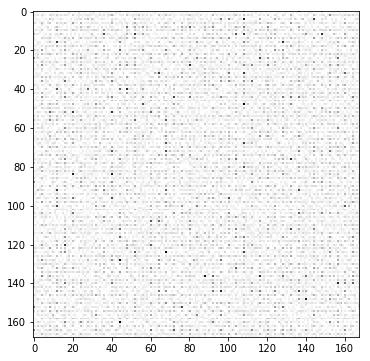

Step 100: Generator Loss: 1.575242, Discriminator Loss: 0.990958


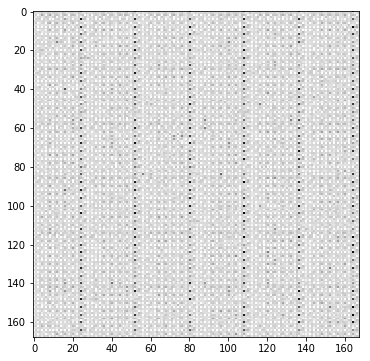

Step 200: Generator Loss: 3.177680, Discriminator Loss: 0.144837


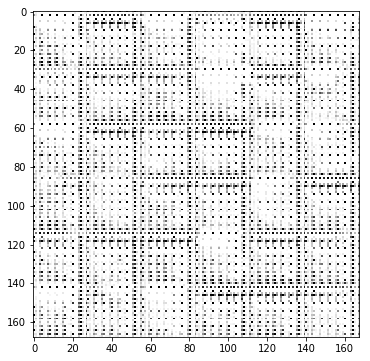

ResourceExhaustedError: OOM when allocating tensor with shape[128,128,7,7] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Discriminator_1/add_8 = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Discriminator_1/mul_12, Discriminator_1/mul_13)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: add/_461 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17491_add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Discriminator_1/add_8', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-62ba966c32d4>", line 135, in <module>
    disc_fake = discriminator(gen_sample, reuse=True)
  File "<ipython-input-4-62ba966c32d4>", line 118, in discriminator
    x = residual_block(x, filters=128, strides=(2, 2), projection_shortcut = projection_shortcut)
  File "<ipython-input-4-62ba966c32d4>", line 26, in residual_block
    conv2_batch_norm_relu = leakyrelu(conv2_batch_norm)
  File "<ipython-input-4-62ba966c32d4>", line 10, in leakyrelu
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 971, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 296, in add
    "Add", x=x, y=y, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,128,7,7] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Discriminator_1/add_8 = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Discriminator_1/mul_12, Discriminator_1/mul_13)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: add/_461 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17491_add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [6]:
# Start Training
# Start a new TF session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# Run the initializer
sess.run(init)
    
# Training
for i in range(1, num_steps+1):

    # Prepare Input Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    # Rescale to [-1, 1], the input range of the discriminator
    batch_x = batch_x * 2. - 1.

    # Discriminator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})
    
    # Generator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, is_training:True})
    
    if i % 100 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        test_display()